In [339]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sqlite3
import scipy
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures

# 1 Успешность прототипа

Известно что компания конкурент выпустила 1000 прототипов игр, из которых было 5 успешных. Наша компания выпустила 200 прототипов из которых ни один не был успешен.
Какова вероятность что следующий (201й) наш прототип будет успешен? Решите задачу классическим и баесовским подходами.

__Ответ:__ Будем считать, что успешность прототипа имеет одинаковое распределение для компании-конкурента и нашей. Дополнительно примем, что результаты разных прототипов являются $iid$. Вероятность успеха каждого прототипа имеет распределение Бернулли с параметром $\theta$. 
Следовательно, каждый прототип будет успешным с вероятностью $\theta$ и неудачным с вероятностью $1-\theta$.


__Классический подход:__

Частотный подход предполагает вероятность успеха как доля успешных прототипов в бесконечной серии. В таком случае эффективной оценкой вероятности успеха каждого прототипа будет являться $\hat{P}(\text{Success}) = \hat{\theta} = \frac{5}{1000} = 0.005$. Следовательно, вероятность, что 201-й прототип окажется успешным, равна 

$\hat{P}(\text{201_is_success = 1}) = \hat{P}(\text{Success = 1}) = \hat{\theta} = 0.005$.

__Байесовский подход:__

В случае с байесовским подходом мы считаем $\theta$ случайной величиной и обновляем априорное распределение вероятности успеха, равное 0.005, в соответствии с информацией, полученной из 200 ранее нами созданных прототипов:

$P(\theta| \text{200 Failures}) = f(\theta) \cdot \frac{P(\text{200 Failures} | \theta)}{P(\text{200 Failures})} $

Вероятность $P(\text{200 Failures |} \theta)$ имеет биномиальное распределение, а $P(\text{200 Failures})$ отражает вероятность 200 неудач при любых возможных значениях вероятности успеха. Cледовательно, 

$P(\theta| \text{200 Failures}) = 0.005 \cdot \frac{(1-\theta)^{200} \cdot  \theta^0}{\int_{0}^1 0.005 \cdot (1-\theta)^{200} \cdot \theta d \theta} = \frac{(1-\theta)^{200} \cdot  \theta^0}{\int_{0}^1 (1-\theta)^{200} \theta^0 d \theta} = f(\theta| \text{200 Failures}) \sim \beta(1, 201)$

# 2. Сравнение групп платящих игроков

В мобильной игре около 10% игроков совершает платежи в первый месяц с момента установки игры (база расчета - 500 игроков). 
Геймдизайнеры разработали обновление которое по их экспертной оценке должно увеличить процент плательщиков с 10% до 11%. Цель эксперимента - подтвердить или опровергнуть их гипотезу.

1. Опишите оптимальный по вашему мнению дизайн эксперимента

__Ответ:__
    
1. Оптимальный дизайн эксперимента представляет из себя классическое А/Б-тестирование, где каждый из приходящих игроков случайным образом получает или стандартную версию игры (контрольная группа), или версию с обновлением (экспериментальная группа). Далее для каждого игрока фиксируется факт совершения внутриигровой покупки в течение первого месяца (1 - совершил покупку, 0 - не совершил).

2.	Рассчитайте длительность эксперимента при условии что каждый день в игру приходит около 100 новых игроков.

__Ответ:__ Взяв стандартные показатели мощности ($1-\beta=80\text{%}$) и значимости ($\alpha = 5\text{%}$) теста, рассчитаем длительность теста по следующей формуле:
$$n_{\text{one group}} = \frac{(\sigma^2_A + \sigma^2_B) \cdot (Z_{\alpha/2} + Z_{\beta})^2}{MDE^2}$$

$\sigma^2_A$ - дисперсия игроков в группе А \
$\sigma^2_B$ - дисперсия игроков в группе B \
$\text{MDE}$ - Minimal detectable effect

Данный формула достаточно известна по калькулятору Эвана Миллера и позволяет учесть ошибки I-го и II-рода, а также минимальный наблюдаемый эффект (minimal detectable effect).

In [291]:
alpha = 0.05
beta = 0.2
p1 = 0.1
p2 = 0.11

n = (p1*(1-p1) + p2*(1-p2)) * (scipy.stats.norm.ppf(alpha/2) + scipy.stats.norm.ppf(beta))**2 / (p2-p1)**2

print(f'Необходимое число игроков в одной группе: {round(n)}')
print(f'Общее необходимое числов игроков: {2 * round(n)}')
print(f'Количество дня для проведения эксперимента: {round(2 * round(n) / 100)}')

Необходимое число игроков в одной группе: 14748
Общее необходимое числов игроков: 29496
Количество дня для проведения эксперимента: 295


3. Самостоятельно сгенерируйте датасет с около 10% плательщиков (контроль) и рассчитайте 95% HDI / CI. 

__Ответ:__ Факт совершения покупки отдельным игроком может быть описан распределением Бернулли с вероятностью успеха $p=0.1$. 

In [297]:
np.random.seed(42)
n=14748

control = np.random.binomial(1, 0.1, size=n)
print(f'Выборочное среднее: {round(control.mean(), 3)}')

Выборочное среднее: 0.098


__95% Confidence interval:__

CI: $\hat{p}_1 + Z_{\alpha / 2} \cdot \frac{\sigma}{\sqrt{n}} \leq p_1 \leq \hat{p}_1 + Z_{1 - \alpha / 2} \cdot \frac{\sigma}{\sqrt{n}}$

In [315]:
left_bound = control.mean() - scipy.stats.norm.ppf(0.975) * control.std() / np.sqrt(n)
right_bound = control.mean() + scipy.stats.norm.ppf(0.975) * control.std() / np.sqrt(n)

print(f'95% Confidence interval: [{round(left_bound, 10)}, {round(right_bound, 10)}]')

95% Confidence interval: [0.0935130601, 0.103123772]


__95% High density interval:__

In [310]:
print(f'Количество игроков, соверших покупку в первый месяц: {control.sum()}')

Количество игроков, соверших покупку в первый месяц: 1450


Здесь как и в предыдущем задании вероятность покупки каждый игроком описывается распределением Бернулли с параметром $\theta$. Априорно считаем, что $\theta=0.1$ (на основе изначального расчета). Тогда

$ f(\theta| \text{14748 users}) = 0.1 \cdot \frac{\theta^{1450} \cdot (1-\theta)^{13298}}{\int_0^1 0.1 \cdot \theta^{1450} \cdot (1-\theta)^{13298} d \theta} \sim \beta(1451, 13299)$

In [314]:
print(f'95% HDI: {scipy.stats.beta.interval(0.95, 1451, 13299)}')

95% HDI: (0.09361868336620141, 0.10323023604389701)


4.	Сгенерируйте несколько вариантов экспериментальной группы (хуже, лучше, без эффекта), рассчитайте силу эффекта, HDI / CI и ваши выводы для каждого варианта.

In [333]:
np.random.seed(42)
better_treatment = np.random.binomial(1, 0.11, size=n)
worse_treatment = np.random.binomial(1, 0.09, size=n)
equal_treatment = np.random.binomial(1, 0.1, size=n)

Рассчитаем размер эффекта при помощи показателя d Коэна.

In [306]:
d1 = (better_treatment.mean() - control.mean()) / ((((control - control.mean())**2).sum() + ((better_treatment - better_treatment.mean())**2).sum()) / (2 * n - 1))
d2 = (worse_treatment.mean() - control.mean()) / ((((control - control.mean())**2).sum() + ((worse_treatment - worse_treatment.mean())**2).sum()) / (2 * n - 1))
d3 = (equal_treatment.mean() - control.mean()) / ((((control - control.mean())**2).sum() + ((equal_treatment - equal_treatment.mean())**2).sum()) / (2 * n - 1))

print(f'Размер эффекта для группы лучше: {d1}')
print(f'Размер эффекта для группы хуже: {d2}')
print(f'Размер эффекта для группы без эффекта: {d3}')

Размер эффекта для группы лучше: 0.11113085342934971
Размер эффекта для группы хуже: -0.11362197320682065
Размер эффекта для группы без эффекта: 0.03692305043199882


Видно, что для групп лучше и хуже эффект присутствует, но его размер достаточно маленький (<0.2). Для группы без эффекта размер эффекта почти нулевой.

__Frequentist:__

CI: $(\hat{p}_B -\hat{p}_A) + Z_{\alpha / 2} \cdot \frac{\sigma_{B-A}}{\sqrt{n}} \leq (p_B - p_A) \leq (\hat{p}_B -\hat{p}_A) + Z_{1 - \alpha / 2} \cdot \frac{\sigma_{B-A}}{\sqrt{n}}$

In [318]:
left_bound_b = better_treatment.mean() - control.mean() - scipy.stats.norm.ppf(0.975) * (control - better_treatment).std() / np.sqrt(n)
right_bound_b = better_treatment.mean() - control.mean() + scipy.stats.norm.ppf(0.975) * (control - better_treatment).std() / np.sqrt(n)

left_bound_w = worse_treatment.mean() - control.mean() - scipy.stats.norm.ppf(0.975) * (control - worse_treatment).std() / np.sqrt(n)
right_bound_w = worse_treatment.mean() - control.mean() + scipy.stats.norm.ppf(0.975) * (control - worse_treatment).std() / np.sqrt(n)

left_bound_e = equal_treatment.mean() - control.mean() - scipy.stats.norm.ppf(0.975) * (control - equal_treatment).std() / np.sqrt(n)
right_bound_e = equal_treatment.mean() - control.mean() + scipy.stats.norm.ppf(0.975) * (control - equal_treatment).std() / np.sqrt(n)

print(f'95% Confidence interval Better experimental group: [{round(left_bound_b, 4)}, {round(right_bound_b, 4)}]')
print(f'95% Confidence interval Worse experimental group: [{round(left_bound_w, 4)}, {round(right_bound_w, 4)}]')
print(f'95% Confidence interval Equal experimental group: [{round(left_bound_e, 4)}, {round(right_bound_e, 4)}]')

95% Confidence interval Better experimental group: [0.0087, 0.0119]
95% Confidence interval Worse experimental group: [-0.0163, -0.003]
95% Confidence interval Equal experimental group: [-0.0035, 0.0101]


Гипотеза о том, что в экспериментальной группе процент покупок выше на 1% не отвергается для группы лучшей и без изменений (0.01 входит в доверительный интервал), но отвергается для худшей.

In [362]:
print(f'(better_treatment == 1).sum() = {(better_treatment == 1).sum()}')

(better_treatment == 1).sum() = 1602


__Bayesian:__
    
$f(\theta) = 0.01$

$f(\theta | data) = 0.01 \cdot \frac{\theta^{1602} \cdot (1-\theta)^{12146}}{\int_0^1 0.01 \cdot \theta^{1602} \cdot (1-\theta)^{12146} d\theta} \sim \beta(1603, 12147)$

In [364]:
b_count = (better_treatment == 1).sum()
print(f'95% HDI для лучшей группы: {scipy.stats.beta.interval(0.95, b_count, 13748-b_count + 1)}')

95% HDI для лучшей группы: (0.1112078789306941, 0.1219329188604131)


Аналогично для двух остальных групп

In [365]:
w_count = (worse_treatment == 1).sum()
print(f'95% HDI для худшей группы: {scipy.stats.beta.interval(0.95, w_count, 13748 - w_count + 1)}')

95% HDI для худшей группы: (0.09028620893430529, 0.1000937332276875)


In [366]:
e_count = (equal_treatment == 1).sum()
print(f'95% HDI для группы без разницы: {scipy.stats.beta.interval(0.95, e_count, 13748 - e_count + 1)}')

95% HDI для группы без разницы: (0.10387078447187569, 0.11428916940231125)


5. Решите задачу 2 разными подходами: frequentist / bayesian

# 3. Предсказание оттока

В мобильной игре, после установки и запуска игры начинается туториал - игрок проходит обучение игре, которое состоит из нескольких последовательных шагов. 
Данные представляют собой набор строк - уникальный id игрока, datetime и номер шага туториала который пройден игроком.
Геймдизайнеры выдвинули гипотезу - если мы с высокой вероятностью сможем предсказать шаг на котором игрок уйдет из игры заранее, то запустив альтернативное продолжение туториала с этого шага мы избежим оттока и увеличим прохождение туториала.


1. Как бы вы решали задачу предсказания отвала игрока?

__Ответ:__ Данный кейс представляет собой задачу множественной классификации, где для каждого игрока предсказывается вероятность отвала на каждом шаге туториала. Если вероятность отвала на каком-то шаге достаточно высокая (например, выше 0.5), то модель считает, что игрок захочет уйти на этом шаге, и запускает альтернативное продолжение туториала. Оптимальный порог для предсказывания может быть подобран таким образом, чтобы максимизировать таргетируемую метрику на валидационной выборке или кросс-валидации.

2. Как оценить качество полученной модели? Опишите методы которые знаете и какой считаете оптимальным и почему.

__Ответ:__ В зависимости от конкретных целей существуют следующие метрики качества модели: accuracy, precision, recall, f-score, ROC-AUC и пр. В решении данной конкретной задачи было бы полезно оценить стоимость каждого вида прогнозов (TP, FP, TN, FN), чтобы более точно понять какая метрика является оптимальной. Из общих соображений можно предположить, что нам нужно выявить как можно большую долю игроков из числа тех, которые хотят уйти, чтобы сохранить их при помощи альтернативного туториала, то есть, мы таргетируем метрику $recall=\frac{TP}{TP+FN}$ (доля найденных моделью уходящих игроков среди всех уходящих). При этом видится, что если альтернативное продолжение будет запущено для игрока, который не собирался уходить (FP), то это не так страшно. При этом очевидно, что если запускать альтернативный туториал для всех игроков (модель всегда предсказывает уход), это максимизирует $recall$, однако $precision$ модели будет низким. Если считать, что ошибка FP тоже нежелательна, подойдет метрика $f\text{-}score$, учитывающая $precison$, но отдающая большее предпочтение $recall$ с ростом параметра $\beta$. Важно учесть, что для многоклассовой класификации нужно совершить микро- или макроусреднение метрик. Альтернативно, для многоклассовой классификации существуют такие метрики, как каппа Коэна или коэффициент корреляции Мэтьюза, однако они менее популярны.

3.	Предположим что вы разработали модель которая с достаточной вероятностью предсказывает отвал. Опишите дизайн эксперимента и методологию по проверке гипотезы геймдизайнеров.

__Ответ:__ Теперь игроки, для которых модель (достаточно точно) предсказала отвал, могут участвовать в новом А/Б-тесте, в рамках которого для них случайным образом будет запущено альтернативное продолжение туториала (экспериментальная группа) или ничего не изменится (контрольная группа). Далее при помощи разных подходов можно оценить разницу в долях оставшихся игроков в обеих группах, сделав тем самым выводы об эффективности альтернативного продолжения и верности выдвинутой гипотезы.

# 4. Эффективность рекламных кампаний

1. Отдел маркетинга руководствуется гипотезой - чем больший COST расходуется на кампанию тем ниже ROAS 60го дня (рост CPI при увеличении объёма закупки при сохранении того же LTV 60го дня). На основании данных подтвердите или опровергните эту гипотезу. Исходите из того что мы точно знаем что CPI зависит от объема нелинейно, вопрос в том как эту зависимость описать и учесть во 2м вопросе.

В базе данных находятся три таблицы с информацией о расходах (costs), доходах (revenue) и источниках (source_comparision). 

In [106]:
db = sqlite3.connect('testcase.db')
cursor = db.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

tables

[('source_comparison',), ('costs',), ('revenue',)]

Для данной задачи нам понадобятся только две из них - о расходах и доходах. Переформатируем их в pandas dataframe для удобства работы.

In [107]:
costs = pd.read_sql_query('SELECT * FROM costs', db)
revenue = pd.read_sql_query('SELECT * FROM revenue', db) 

print(f'costs columns: {costs.columns}')
print(f'revenue columns: {revenue.columns}')

costs columns: Index(['Install_Dates', 'campaign_id', 'Country', 'installs', 'spends'], dtype='object')
revenue columns: Index(['Install_Dates', 'campaign_id', 'Country', '1d_LTV', '3d_LTV', '7d_LTV',
       '14d_LTV', '30d_LTV', '60d_LTV'],
      dtype='object')


In [259]:
df = costs.merge(revenue, on=['Install_Dates', 'campaign_id', 'Country'])
df.head()

,Install_Dates,campaign_id,Country,installs,spends,1d_LTV,3d_LTV,7d_LTV,14d_LTV,30d_LTV,60d_LTV
0,2020-04-14,90570,CZ,35.0,19.79,7.721194,8.104811,10.209480,11.845200,15.349594,15.768420
1,2020-04-28,90619,AT,5.0,4.99,1.032342,1.032342,1.248888,1.501317,1.761729,-1.000000
2,2020-05-10,794235,PK,79.0,0.40,0.212500,0.254620,0.390186,0.519535,0.652006,-1.000000
3,2020-05-07,91872,FR,12.0,9.56,4.661390,4.787784,6.422362,6.596973,6.596973,-1.000000
4,2020-04-03,19115,JP,6.0,3.39,0.833442,0.833442,1.103046,1.167516,1.398647,1.416652


ROAS на 60-й день для каждой i-й рекламной компании может быть рассчитан как $\text{ROAS}_i = \frac{\text{60d_LTV}}{\text{spends}} \cdot 100\text{%}$ 

In [341]:
df['60d_ROAS'] = df['60d_LTV'] / df['spends'] * 100
df

,Install_Dates,campaign_id,Country,installs,spends,1d_LTV,3d_LTV,7d_LTV,14d_LTV,30d_LTV,60d_LTV,best_installs,best_budget,diff,status,60d_ROAS
0,2020-04-14,90570,CZ,35.0,19.79,7.721194,8.104811,10.209480,11.845200,15.349594,15.768420,31.966315,349.876273,-342.773727,cut,79.678728
1,2020-04-28,90619,AT,5.0,4.99,1.032342,1.032342,1.248888,1.501317,1.761729,-1.000000,0.000000,0.000000,-24.950000,stop,-20.040080
2,2020-05-10,794235,PK,79.0,0.40,0.212500,0.254620,0.390186,0.519535,0.652006,-1.000000,0.000000,0.000000,-31.600000,stop,-250.000000
3,2020-05-07,91872,FR,12.0,9.56,4.661390,4.787784,6.422362,6.596973,6.596973,-1.000000,0.000000,0.000000,-114.720000,stop,-10.460251
4,2020-04-03,19115,JP,6.0,3.39,0.833442,0.833442,1.103046,1.167516,1.398647,1.416652,0.000000,0.000000,-20.340000,stop,41.789143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10201,2020-04-02,90464,UN,0.0,0.45,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,stop,0.000000
10202,2020-04-27,19115,DE,27.0,21.33,31.003103,36.859179,45.552113,52.804398,58.205993,-1.000000,0.000000,0.000000,-575.910000,stop,-4.688233
10203,2020-03-27,159253,DK,2.0,0.19,0.351962,0.351962,0.386234,0.448579,0.564261,0.693104,0.000000,0.000000,-0.380000,stop,364.791594
10204,2020-04-12,790034,RU,534.0,81.06,47.323662,56.483875,65.396237,75.178386,85.603100,92.690140,278.517898,13629.239907,-29656.800093,cut,114.347569


На очень скорую руку можно прогнать регрессию ROAS на COST и посмотреть на коэффициент перед COST. К сожалению, я не успеваю нормально обработать данные или использовать более сложные методы.

In [348]:
model = sm.OLS(df.loc[df['60d_ROAS'] >=0, '60d_ROAS'], sm.add_constant(df.loc[df['60d_ROAS'] >=0, 'installs'] * df.loc[df['60d_ROAS'] >=0, 'spends']))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               60d_ROAS   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.2574
Date:                Sun, 28 Jul 2024   Prob (F-statistic):              0.612
Time:                        02:50:30   Log-Likelihood:                -35729.
No. Observations:                4578   AIC:                         7.146e+04
Df Residuals:                    4576   BIC:                         7.148e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        172.0568      8.810     19.530      0.000     154.785     189.329
0          -2.887e-05   5.69e-05     -0.507      0.612      -0.000    8.27e-05
==============================================================================
Omnibus:                     9516.193   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         33611479.393
Skew:                          17.600   Prob(JB):                         0.00
Kurtosis:                     421.292   Cond. No.                     1.56e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.56e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Как можно заметить, коэф перед COST отрицательный, однако он незначим на любом разумной уровне значимости. Следовательно, гипотеза отвергается.

2. По каждой рекламной кампании рассчитайте суточный рекламный бюджет который максимизирует абсолютную маркетинговую прибыль рекламной кампании (REVENUE 60 дня минус COST).

__Ответ:__ Знаем, что связь между CPI (столбец 'spends') и количеством скачиваний (столбец 'installs') может быть нелинейной. Для этого сначала посмотрим на диаграмму рассеивания:

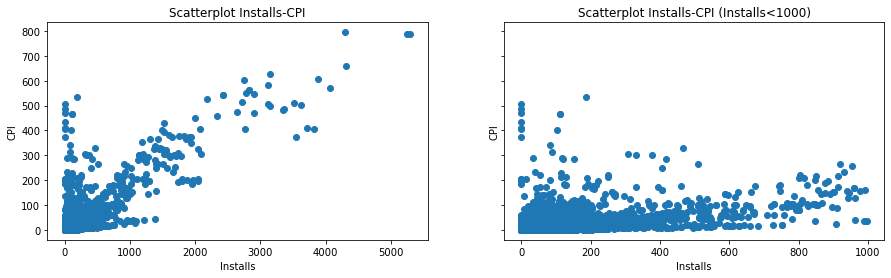

In [141]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.set_figwidth(15)

ax1.scatter(df['installs'], df['spends'])
ax1.set_xlabel('Installs')
ax1.set_ylabel('CPI')
ax1.set_title('Scatterplot Installs-CPI')

ax2.scatter(df[df['installs'] < 1000]['installs'], df[df['installs'] < 1000]['spends'])
ax2.set_xlabel('Installs')
ax2.set_ylabel('CPI')
ax2.set_title('Scatterplot Installs-CPI (Installs<1000)')
plt.show()

Если смотреть на диаграмму всех данных, то кажется, что они неплохо описываются линейной зависимостью, однако если посмотреть отдельно на диаграмму для кампаний, привлекших меньше 1000 скачиваний, то видно, что при относительно небольших объемах CPI практически не меняется (или усредненная прямая имеет очень маленький наклон), а с ростом объемов этот наклон растет. Чтобы подобрать оптимальную функциональную форму для описания данных, можно обучить lasso-регрессию, включив туда различные степени зависимой переменной. Получив функциональную форму, которая бы хороша описывала данные, в дальнейшем мы сможем достаточно легко оптимизировать прибыль каждой кампании.

In [212]:
lasso = Lasso()
pol_features = PolynomialFeatures(3, include_bias=False)
polinoms = pol_features.fit_transform(np.array(df['installs']).reshape(-1, 1))
lasso.fit(polinoms, df['spends'])
print(f'a1, a2, a3 = {lasso.coef_}')
print(f'const = {lasso.intercept_}')

a1, a2, a3 = [ 1.50372093e-01  1.36520183e-05 -3.03330873e-09]
const = 6.136056566115032


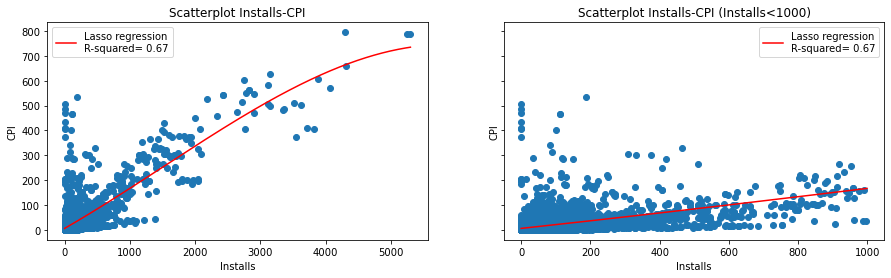

In [210]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.set_figwidth(15)

ax1.scatter(df['installs'], df['spends'])
ax1.set_xlabel('Installs')
ax1.set_ylabel('CPI')
ax1.set_title('Scatterplot Installs-CPI')
ax1.plot(np.arange(max(df['installs'])),
         lasso.intercept_ + np.multiply(lasso.coef_,
         pol_features.fit_transform(np.arange(max(df['installs'])).reshape(-1, 1))).sum(axis=1),
         c='r',
         label=f"Lasso regression\nR-squared= {round(lasso.score(polinoms, df['spends']), 2)}")
ax1.legend()

ax2.scatter(df[df['installs'] < 1000]['installs'], df[df['installs'] < 1000]['spends'])
ax2.set_xlabel('Installs')
ax2.set_ylabel('CPI')
ax2.set_title('Scatterplot Installs-CPI (Installs<1000)')
ax2.plot(np.arange(1000),
         lasso.intercept_ + np.multiply(lasso.coef_,
         pol_features.fit_transform(np.arange(1000).reshape(-1, 1))).sum(axis=1),
         c='r',
         label=f"Lasso regression\nR-squared= {round(lasso.score(polinoms, df['spends']), 2)}")
ax2.legend()
plt.show()

Видно, что полученная регрессия в среднем достаточно неплохо описывает данные, однако коэффициент детерминации $R^2$ не очень высокий, что обусловлено очень высокой шумностью исходных данных.

Итоговая взаимосвязь, которая будет использована для оптимизации прибыли в каждой кампании, выглядит следующим образом: 

$CPI = 6.136 + 0.15 \cdot \text{Installs} + 0.000014 \cdot \text{Installs}^2 - 0.000000003 \cdot \text{Installs}^3$

Так как считаем, что LTV_60d не меняется от объема, то для i-й кампании прибыль будет следующей:

$\text{Profit}_i = (\text{LTV_60d}_i - \text{CPI}_i(\text{Installs}_i)) \cdot \text{Installs}_i$

In [260]:
# Оптимизируем бюджет для каждой кампании
for i in df.index:
    func = lambda x: -1 * (df.iloc[i]['60d_LTV'] - 6.136 - 0.15 * x - 0.000014 * x ** 2 + 0.000000003 * x ** 3) * x
    df.loc[i, 'best_installs'] = scipy.optimize.minimize(func, df.iloc[i]['installs']).x

In [261]:
df.loc[df['best_installs'] < 0, 'best_installs'] = 0
df.loc[:, 'best_budget'] = (6.136 + 0.15 * df['best_installs']
                            + 0.000014 * df['best_installs'] ** 2
                            - 0.000000003 * df['best_installs'] ** 3) * df['best_installs']

df

,Install_Dates,campaign_id,Country,installs,spends,1d_LTV,3d_LTV,7d_LTV,14d_LTV,30d_LTV,60d_LTV,best_installs,best_budget
0,2020-04-14,90570,CZ,35.0,19.79,7.721194,8.104811,10.209480,11.845200,15.349594,15.768420,31.966315,349.876273
1,2020-04-28,90619,AT,5.0,4.99,1.032342,1.032342,1.248888,1.501317,1.761729,-1.000000,0.000000,0.000000
2,2020-05-10,794235,PK,79.0,0.40,0.212500,0.254620,0.390186,0.519535,0.652006,-1.000000,0.000000,0.000000
3,2020-05-07,91872,FR,12.0,9.56,4.661390,4.787784,6.422362,6.596973,6.596973,-1.000000,0.000000,0.000000
4,2020-04-03,19115,JP,6.0,3.39,0.833442,0.833442,1.103046,1.167516,1.398647,1.416652,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10201,2020-04-02,90464,UN,0.0,0.45,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10202,2020-04-27,19115,DE,27.0,21.33,31.003103,36.859179,45.552113,52.804398,58.205993,-1.000000,0.000000,0.000000
10203,2020-03-27,159253,DK,2.0,0.19,0.351962,0.351962,0.386234,0.448579,0.564261,0.693104,0.000000,0.000000
10204,2020-04-12,790034,RU,534.0,81.06,47.323662,56.483875,65.396237,75.178386,85.603100,92.690140,278.517898,13629.239907


Получили достаточно логичные результаты!

3. Исходя из пункта 2 по каждой рекламной кампании дайте ваше заключение о том насколько нужно увеличить / уменьшить ее суточный бюджет либо вообще остановить.

In [262]:
df['diff'] = df['best_budget'] - df['installs'] * df['spends']
df['status'] = 'cut'
df.loc[df['diff'] > 0, 'status'] = 'rise'
df.loc[df['diff'] == 0, 'status'] = 'keep'
df.loc[df['best_installs'] == 0, 'status'] = 'stop'

df

,Install_Dates,campaign_id,Country,installs,spends,1d_LTV,3d_LTV,7d_LTV,14d_LTV,30d_LTV,60d_LTV,best_installs,best_budget,diff,status
0,2020-04-14,90570,CZ,35.0,19.79,7.721194,8.104811,10.209480,11.845200,15.349594,15.768420,31.966315,349.876273,-342.773727,cut
1,2020-04-28,90619,AT,5.0,4.99,1.032342,1.032342,1.248888,1.501317,1.761729,-1.000000,0.000000,0.000000,-24.950000,stop
2,2020-05-10,794235,PK,79.0,0.40,0.212500,0.254620,0.390186,0.519535,0.652006,-1.000000,0.000000,0.000000,-31.600000,stop
3,2020-05-07,91872,FR,12.0,9.56,4.661390,4.787784,6.422362,6.596973,6.596973,-1.000000,0.000000,0.000000,-114.720000,stop
4,2020-04-03,19115,JP,6.0,3.39,0.833442,0.833442,1.103046,1.167516,1.398647,1.416652,0.000000,0.000000,-20.340000,stop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10201,2020-04-02,90464,UN,0.0,0.45,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,stop
10202,2020-04-27,19115,DE,27.0,21.33,31.003103,36.859179,45.552113,52.804398,58.205993,-1.000000,0.000000,0.000000,-575.910000,stop
10203,2020-03-27,159253,DK,2.0,0.19,0.351962,0.351962,0.386234,0.448579,0.564261,0.693104,0.000000,0.000000,-0.380000,stop
10204,2020-04-12,790034,RU,534.0,81.06,47.323662,56.483875,65.396237,75.178386,85.603100,92.690140,278.517898,13629.239907,-29656.800093,cut


Столбец 'dif' показывает, насколько текущий бюджет отличается от оптимального, cтолбец 'status' указывает на оптимальное действие - повышение или снижение бюджета или полная остановка кампании.

4. Решите проблему рекламных кампаний по которым еще нет полных 60 дней. Объясните почему ваше решение оптимально

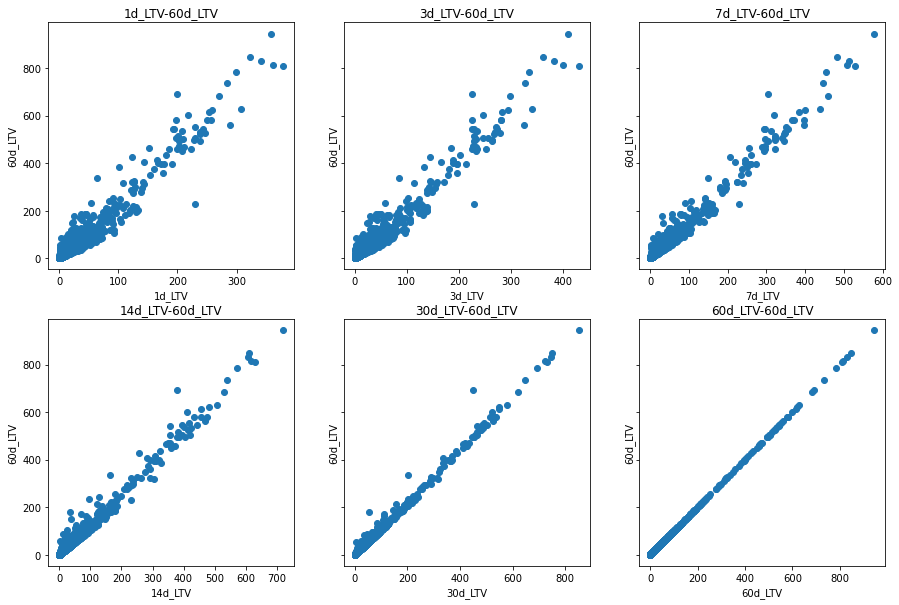

In [273]:
campaigns_60d = df[df['60d_LTV'] != -1]

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharey=True)
fig.set_figwidth(15)
fig.set_figheight(10)

ax1.scatter(campaigns_60d['1d_LTV'], campaigns_60d['60d_LTV'])
ax1.set_xlabel('1d_LTV')
ax1.set_ylabel('60d_LTV')
ax1.set_title('1d_LTV-60d_LTV')

ax2.scatter(campaigns_60d['3d_LTV'], campaigns_60d['60d_LTV'])
ax2.set_xlabel('3d_LTV')
ax2.set_ylabel('60d_LTV')
ax2.set_title('3d_LTV-60d_LTV')

ax3.scatter(campaigns_60d['7d_LTV'], campaigns_60d['60d_LTV'])
ax3.set_xlabel('7d_LTV')
ax3.set_ylabel('60d_LTV')
ax3.set_title('7d_LTV-60d_LTV')

ax4.scatter(campaigns_60d['14d_LTV'], campaigns_60d['60d_LTV'])
ax4.set_xlabel('14d_LTV')
ax4.set_ylabel('60d_LTV')
ax4.set_title('14d_LTV-60d_LTV')

ax5.scatter(campaigns_60d['30d_LTV'], campaigns_60d['60d_LTV'])
ax5.set_xlabel('30d_LTV')
ax5.set_ylabel('60d_LTV')
ax5.set_title('30d_LTV-60d_LTV')

ax6.scatter(campaigns_60d['60d_LTV'], campaigns_60d['60d_LTV'])
ax6.set_xlabel('60d_LTV')
ax6.set_ylabel('60d_LTV')
ax6.set_title('60d_LTV-60d_LTV')

plt.show()

На основе кампаний, где есть полные 60 дней, можно видеть, что связь LTV 60-го дня с LTV более ранних периодов почти что линейная (LTV 30-го дня практически совпадает с LTV 60-го). Следовательно, для более недавних кампаний можно можно построить линейную модель, предсказывающую LTV 60-го дня и строить оптимальный бюджет, исходя из прогноза. Такой подход будет вполне оптимальным, так как связь в данных достаточно низкая дисперсия, что позволяет дать весьма точный прогноз при помощи линейной модели.

# 5. Связь рекламного трафика и органического

Приток новых игроков делится на 2 основных источника - рекламный и органический. Отдел маркетинг выдвигает гипотезу о связи рекламного и органического траффика: когда маркетологи привлекают больше рекламного траффика, растет и органический.
Для выполнения задачи необходимо использовать тестовый датасет (таблица source_comparison).

In [34]:
source_comparison = pd.read_sql_query("SELECT * FROM source_comparison", db) 
source_comparison.head()

,Install_Dates,source_type,Country,installs
0,2020-05-18,Paid,PY,4.0
1,2020-04-14,Paid,FR,35.0
2,2020-04-30,Paid,JP,25.0
3,2020-03-20,Paid,DE,11.0
4,2020-04-30,Paid,IT,8.0


1. Используя Causal Impact Analysis подтвердите или опровергните гипотезу маркетологов. Если вы ее опровергаете, то сформулируйте гипотезу которая кажется вам наиболее вероятной и проверьте ее

In [55]:
source_comparison = source_comparison.sort_values(by=['Install_Dates'])
organic = source_comparison[source_comparison['source_type'] == 'Organic'].groupby(by='Install_Dates').sum()
paid = source_comparison[source_comparison['source_type'] == 'Paid'].groupby(by='Install_Dates').sum()

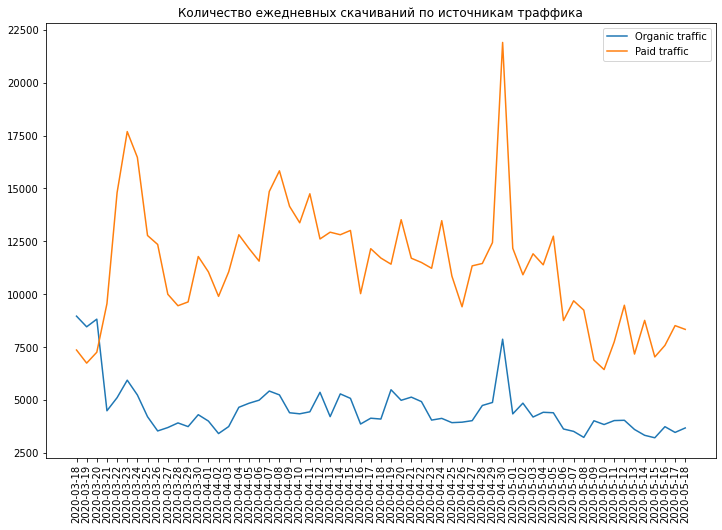

In [275]:
plt.figure(figsize=(12,8))
plt.title('Количество ежедневных скачиваний по источникам траффика')
plt.plot(organic.index, organic.values, label='Organic traffic')
plt.plot(paid.index, paid.values, label='Paid traffic')
plt.xticks(rotation=90)
plt.legend()
plt.show()

Не совсем понятно в какой момент здесь начинается treatment, так как данные paid трафик есть все время.

Не успеваю доделать.